## Is deformation radius important for model training?

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import sys
sys.path.append('../modules/')

In [3]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2024-10-10 17:58:23.298955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 17:58:23.298982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 17:58:23.300343: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
experiment_config= {'experiment_name': 'deformation_radius', # Any sort of name will work here 
                    'simulation_names':['DG','P2L'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':1, 
                    
                    'input_channels' : ['dudx_widened',  
                                        'dvdx_widened', 
                                        'dudy_widened',
                                        'dvdy_widened',
                                        'dhdx_widened',
                                        'dhdy_widened',
                                        'dhbardx_widened',
                                        'dhbardy_widened',
                                        'filter_scale'],
                    
                    'output_channels' : ['uphp',
                                         'vphp'],
                    
                    'coeff_channels'  : [], 

                    'all_time_range': slice(0, 1400), 
                    'train_time_range': slice(0, 1200),
                    'test_time_range' : slice(-100, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 
                   
                    'network_shape': [36, 36, 2],
                    'single_layer_mask': False}

experiment_config['all_ml_variables'] = (experiment_config['input_channels'] + 
                                           experiment_config['output_channels'] +
                                           experiment_config['coeff_channels'])

experiment_config['num_inputs'] = (len(experiment_config['input_channels']) - 1)*experiment_config['window_size']**2 + 1

experiment_config['exp_ckpt_save_dir'] = ('/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/raw_models/' + 
                                          '_'.join(experiment_config['simulation_names']) + 
                                          '_' + str(experiment_config['window_size']) + '_with_topo')

In [7]:
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'],
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask=experiment_config['single_layer_mask'])

In [8]:
DT.simulation_data['DG']['100']

DataTree('100', parent="DG")
    Dimensions:                      (Time: 1400, xh: 100, yh: 110, zl: 2, Xn: 1,
                                      Yn: 1, zi: 3)
    Coordinates:
      * Time                         (Time) object 11kB 0001-01-11 00:00:00 ... 0...
      * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
      * yh                           (yh) float64 880B 30.09 30.27 ... 49.73 49.91
      * zl                           (zl) float64 16B 1.035e+03 1.036e+03
      * zi                           (zi) float64 24B 1.034e+03 1.036e+03 1.037e+03
    Dimensions without coordinates: Xn, Yn
    Data variables: (12/64)
        dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 246MB dask.array<chunksize=(36, 2, 110, 100, 1, 1), meta=np.ndarray>
        dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 246MB dask.array<chunksize=(36, 2, 110, 100, 1, 1), meta=np.ndarray>
        dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 246MB dask.array<chunksize=(36, 2, 110, 100, 1, 1), meta=np.ndarray>
        dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 246MB dask.array<chunksize=(36, 2, 110, 100, 1, 1), meta=np.ndarray>
        dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 246MB dask.array<chunksize=(36, 2, 110, 100, 1, 1), meta=np.ndarray>
        dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 246MB dask.array<chunksize=(36, 2, 110, 100, 1, 1), meta=np.ndarray>
        ...                           ...
        dhdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 246MB dask.array<chunksize=(36, 2, 110, 100, 1, 1), meta=np.ndarray>
        uphp_rotated_nondim          (Time, zl, yh, xh) float64 246MB dask.array<chunksize=(36, 2, 110, 100), meta=np.ndarray>
        vphp_rotated_nondim          (Time, zl, yh, xh) float64 246MB dask.array<chunksize=(36, 2, 110, 100), meta=np.ndarray>
        uphp_nondim                  (Time, zl, yh, xh) float64 246MB dask.array<chunksize=(36, 2, 110, 100), meta=np.ndarray>
        vphp_nondim                  (Time, zl, yh, xh) float64 246MB dask.array<chunksize=(36, 2, 110, 100), meta=np.ndarray>
        Rd_nondim                    (Time, yh, xh) float64 123MB dask.array<chunksize=(36, 110, 100), meta=np.ndarray>
    Attributes:
        simulation_name:  DG
        filter_scale:     100
        source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
        description:      Dataset for DG experiment at 100 km resolution

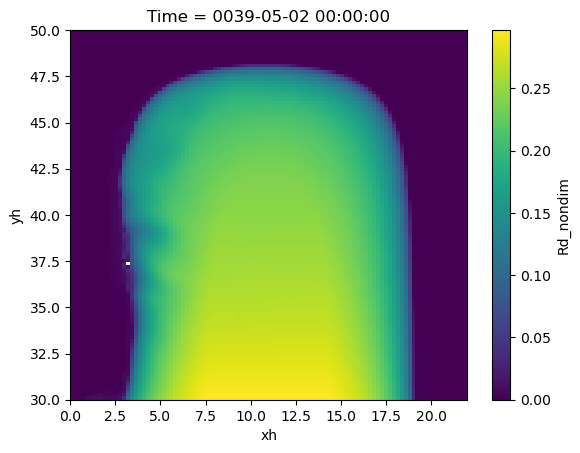

In [12]:
DT.simulation_data['DG']['100'].Rd_nondim.isel(Time=-1).plot()